In [97]:
import matplotlib.pyplot as plt
import stompy.model.delft.dflow_model as dfm
import stompy.model.hydro_model as hm
import xarray as xr
from stompy import utils
import numpy as np
import pandas as pd
from stompy.plot import plot_wkb

import six

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib notebook

Calibration Progress
==

By v014
 * the phase and amplitude are dialed in at SF
 * roughness regions are back to working, with a few new ones added.
 * propagation is too fast (1600s by Redwood, 4000s+ in S Delta)
 * WSE amplitudes too large, generally by 1.35x in the Delta
 * flows also too large.
 
v015 will increase default `n` from 0.02 to 0.028.


In [98]:
import sfb_csc

In [99]:
runs=[
    #dict(run_dir="data_3d_2019_summer-v009", label="3D"),
    #dict(run_dir="data_2d_2019_summer-v008", label="2D"),
    # switch tides to PR
    #dict(run_dir="data_2d_2019_summer-v010", label="2D"),
    # in progress:
    # v011: use that last run to set lag and amplitude at SF
    #dict(run_dir="data_2d_2019_summer-v011", label="2D"),
    # v012: bring the old tuned roughness back in. Had been
    #   running [accidentally] with uniform 0.02 roughness
    #dict(run_dir="data_2d_2019_summer-v012", label="2D"),
    # I think v013 was accidental.
    # v014 includes roughness for more regions outside the original
    # CSC.
    dict(run_dir="data_2d_2019_summer-v014", label="2D"),
]
runs=pd.DataFrame(runs)

In [100]:
six.moves.reload_module(dfm)
six.moves.reload_module(sfb_csc)

runs['model'] = runs['run_dir'].apply(lambda r: sfb_csc.SfbCsc.load(r))

In [101]:
# Dev for stage comparisons
his_ds=runs.loc[0,'model'].his_dataset()


In [102]:
# cross_section geom is coming up strange. Either a bug in DFM snapping or
# output. Some of the coordinates are zero in the hist file.

In [103]:
import stompy.model.data_comparison as dc

class ModelData: 
    data_start=None # will be set from model
    data_stop =None
    def __init__(self,model,**kw):
        utils.set_keywords(self,kw)
        # Might transition this to better caching at some point.
        self.model=model
        self.his=self.model.his_dataset()
        self.data_start=self.his.time.values[0]
        self.data_stop =self.his.time.values[-1]


class DFMStage(ModelData):
    station=None
    
    def __init__(self,model,station):
        super().__init__(model)
        self.station=station
        
    def src_data(self):
        if self.station not in self.his.stations:
            print(f"stations={self.station} not present in his file")
            return None

        da=self.his.sel(stations=self.station)['waterlevel']
        da=da.assign_coords(label='Pred')
        return da
    
    def plot_xy(self):
        if self.station not in self.his.stations: return None
        return [self.his.station_x_coordinate.sel(stations=self.station).values,
                self.his.station_y_coordinate.sel(stations=self.station).values]
    
class DFMFlow(ModelData):
    cross_section=None
    location=None
    
    def __init__(self,model,cross_section,**kw):
        self.cross_section=cross_section
        super().__init__(model,**kw)
        
    def src_data(self):
        if self.cross_section not in self.his.cross_section:
            print(f"cross_section={self.cross_section} not present in his file")
            return None
        da=self.his.sel(cross_section=self.cross_section)['cross_section_discharge']
        da=da.assign_coords(label='Pred')
        return da
    
    def plot_xy(self):
        if self.location is None:
            if self.cross_section not in self.his.cross_section: return None
            linestring=self.his.cross_section_geom.sel(cross_section=self.cross_section).item()
            #return np.array(linestring.coords).mean(axis=0)
            return np.array(linestring.coords)[0,:] # some features have trailing 0?
        elif isinstance(self.location,str):
            # interpret as a station with the given name
            if self.location not in self.his.stations: return None
            return [self.his.station_x_coordinate.sel(stations=self.location).values,
                    self.his.station_y_coordinate.sel(stations=self.location).values]
        else: # assume [x,y]
            return self.location
        
class StationCompare:
    """
    Comparison plots and helpers for station-oriented data
    """
    name=None
    reference=0 # control metric calculation 
    predicted=1 # 
    
    def __init__(self,sources,**kw):
        self.sources=sources
        self.data=None
        utils.set_keywords(self,kw)
        
        if self.name is None:
            self.name=self.sources[0].name    
        
    def plot_xy(self):
        """
        return [x,y] for where this point[ish] comparison should be
        plotted.
        """
        for source in self.sources:
            try:
                xy=source.plot_xy()
                if xy is not None:
                    return xy
            except AttributeError:
                pass
        print("No sources provided a location")
        return [np.nan,np.nan]
        
    def assemble_data(self):
        if self.data is not None:
            return self.data
        
        # See which sources already have a date range.
        # choose the final date range based on those.
        starts=[]
        stops =[]
        for source in self.sources:
            if source.data_start is not None:
                starts.append(source.data_start)
            if source.data_stop is not None:
                stops.append(source.data_stop)
        # will need better logic than this. Maybe test for model vs obs.
        start=min(starts)
        stop =max(stops)
        print(f"Inferred time period: {start} to {stop}")
        
        self.data=[]
        
        labels={}
        for src_i,source in enumerate(self.sources):
            if source.data_start is None:
                source.data_start=start
            if source.data_stop is None:
                source.data_stop =stop
            try:
                da=source.src_data()
            except hm.MissingBCData:
                da=None

            if da is None:
                self.data.append(None)
                continue
                
            if 'label' not in da.coords:
                if isinstance(source,hm.BC):
                    label="Obs"
                elif isinstance(source,ModelData):
                    label="Pred"
            else:
                label=da.label.item()
                
            if label in labels:
                label=label+str(src_i)
            labels[label]=True
            self.data.append(da.assign_coords(label=label))
        return self.data
    
    def calc_metrics(self):
        data=self.assemble_data() # list of dataarrays
        if data[self.reference] is None or data[self.predicted] is None:
            return dict(error="no data")
        else:
            return dc.calc_metrics(data[self.predicted],data[self.reference],combine=True)

    def figure(self):
        self.assemble_data()
        if any([d is None for d in self.data]):
            print("No data - skipping figure")
            return None
        self.combined=dc.combine_sources(self.data)
        fig=dc.calibration_figure_3panel(all_sources=self.data,
                                         metric_x=self.predicted,metric_ref=self.reference,
                                         combined=self.combined)
        fig.axes[0].legend(title=self.name,loc='upper left',bbox_to_anchor=(1,1),
                           frameon=0)
        fig.subplots_adjust(right=0.85,left=0.07,top=0.98,bottom=0.1)
        return fig

class StageCompare(StationCompare):
    pass

class FlowCompare(StationCompare):
    pass

hm.NwisStageBC.cache_dir="cache"
hm.NOAAStageBC.cache_dir="cache"

# maybe a more generic way
comparisons=[
    StageCompare( [ hm.NwisStageBC(11455420,name='SRV') ]
                 + [DFMStage(model,'SRV') for model in runs['model']],
                 name="Rio Vista (SRV)"),
    FlowCompare( [ hm.NwisFlowBC(11455420,name='SRV') ]
                 + [DFMFlow(model,'RioVista') for model in runs['model']],
                 name="Rio Vista (SRV)"),
    

    StageCompare( [ hm.NwisStageBC(11447650,name='FPT') ]
                 + [DFMStage(model,'FPX') for model in runs['model']],
                 name="Freeport"),

    StageCompare( [ hm.NwisStageBC(11455385,name='RYI') ]
                 + [DFMStage(model,'RYI') for model in runs['model']],
                 name="RYI (near match)"),

    # Stage for 2020 to 2023. Has EC much earlier.
    #StageCompare( [ hm.NwisStageBC(11455280,name='HST') ]
    #             + [DFMStage(model,'HST') for model in runs['model']],
    #             name="HST"),

    # Hass near Elmira. Newly added observation point.
    #StageCompare( [ hm.NwisStageBC(11455278,name="HAS") ]
    #             + {DFMStage(model, 'HassElmira') for model in runs['model']],
    #               name="HAS"}
    
    # Newly added station
    StageCompare( [hm.NwisStageBC(11313433, name="DutchSlough")]
                 + [DFMStage(model, 'DSL') for model in runs['model']],
                 name="Dutch Slough"),
    # Newly added section
    FlowCompare( [hm.NwisFlowBC(11313433, name="DutchSlough")]
                 + [DFMFlow(model, 'DSL', location='DSL') for model in runs['model']],
                 name="Dutch Slough"),
    # Jersey Point 
    StageCompare( [hm.NwisStageBC(11337190, name="JerseyPoint")]
                 + [DFMStage(model, 'JPT') for model in runs['model']],
                 name="Jersey Point"),
    FlowCompare( [hm.NwisFlowBC(11337190, name="JerseyPoint")]
                 + [DFMFlow(model, 'JPT',location='JPT') for model in runs['model']],
                 name="Jersey Point"),
    
    # Threemile Slough 
    StageCompare( [hm.NwisStageBC(11337080, name="ThreemileSlough")]
                 + [DFMStage(model, 'TSL') for model in runs['model']],
                 name="Threemile Slough"),
    FlowCompare( [hm.NwisFlowBC(11337080, name="ThreemileSlough")]
                 + [DFMFlow(model, 'TSL',location='TSL') for model in runs['model']],
                 name="Threemile Slough"),
    
    # Delta Cross Channel
    StageCompare( [hm.NwisStageBC(11336600, name="DeltaCrossChannel")]
                 + [DFMStage(model, 'DLC') for model in runs['model']],
                 name="Delta Cross Channel"),
    FlowCompare( [hm.NwisFlowBC(11336600, name="DeltaCrossChannel")]
                 + [DFMFlow(model, 'DLC') for model in runs['model']],
                 name="Delta Cross Channel"),
    
    # Sac below Georgiana
    StageCompare( [hm.NwisStageBC(11447905, name="SacBelowGeorgiana")]
                 + [DFMStage(model, 'GES') for model in runs['model']],
                 name="Sac blw Georgiana"),
    FlowCompare( [hm.NwisFlowBC(11447905, name="SacBelowGeorgiana")]
                 + [DFMFlow(model, 'GES') for model in runs['model']],
                 name="Sac blw Georgiana"),
    
    # Georgiana Sl at Sac River
    StageCompare( [hm.NwisStageBC(11447903, name="Georgiana Sl")]
                 + [DFMStage(model, 'GSS') for model in runs['model']],
                 name="Georgiana Sl"),
    FlowCompare( [hm.NwisFlowBC(11447903, name="Georgiana Sl")]
                 + [DFMFlow(model, 'GSS') for model in runs['model']],
                 name="Georgiana Sl"),
    
    # Sac above DCC
    StageCompare( [hm.NwisStageBC(11447890, name="Sac ab DCC")]
                 + [DFMStage(model, 'SDC') for model in runs['model']],
                 name="Sac ab DCC"),
    FlowCompare( [hm.NwisFlowBC(11447890, name="Sac ab DCC")]
                 + [DFMFlow(model, 'SDC') for model in runs['model']],
                 name="Sac ab DCC"),
    
    # Prisoners Point
    StageCompare( [hm.NwisStageBC(11313460, name="SJ Prisoners Pt")]
                 + [DFMStage(model, 'PRI') for model in runs['model']],
                 name="SJ Prisoners Pt"),
    FlowCompare( [hm.NwisFlowBC(11313460, name="SJ Prisoners Pt")]
                 + [DFMFlow(model, 'PRI') for model in runs['model']],
                 name="SJ Prisoners Pt"),

    # Garwood Bridge 
    StageCompare( [hm.NwisStageBC(11304810, name="SJ Garwood Br")]
                 + [DFMStage(model, 'GAR') for model in runs['model']],
                 name="SJ Garwood Br"),
    FlowCompare( [hm.NwisFlowBC(11304810, name="SJ Garwood Br")]
                 + [DFMFlow(model, 'GAR') for model in runs['model']],
                 name="SJ Garwood Br"),
    
    # Victoria Canal
    StageCompare( [hm.NwisStageBC(11312672, name="Victoria Canal")]
                 + [DFMStage(model, 'VCU') for model in runs['model']],
                 name="Victoria Canal"),
    FlowCompare( [hm.NwisFlowBC(11312672, name="Victoria Canal")]
                 + [DFMFlow(model, 'VCU') for model in runs['model']],
                 name="Victoria Canal"),
    
    # Old River at Byron
    StageCompare( [hm.NwisStageBC(11313315, name="Old River at Byron")]
                 + [DFMStage(model, 'ORB') for model in runs['model']],
                 name="Old River at Byron"),
    FlowCompare( [hm.NwisFlowBC(11313315, name="Old River at Byron")]
                 + [DFMFlow(model, 'ORB') for model in runs['model']],
                 name="Old River at Byron"),
    
    #  Steamboat slough near Walnut Grove
    StageCompare( [hm.NwisStageBC(11447850, name="Steamboat Sl nr Walnut Grove")]
                 + [DFMStage(model, 'SSS') for model in runs['model']],
                 name="Steamboat Sl nr Walnut Gr"),
    FlowCompare( [hm.NwisFlowBC(11447850, name="Steamboat Sl nr Walnut Grove")]
                 + [DFMFlow(model, 'SSS') for model in runs['model']],
                 name="Steamboat Sl nr Walnut Gr"),

    #  Sutter nr courtland
    StageCompare( [hm.NwisStageBC(11447830, name="Sutter Sl a Courtland")]
                 + [DFMStage(model, 'SUT') for model in runs['model']],
                 name="Sutter Sl at Courtland"),
    FlowCompare( [hm.NwisFlowBC(11447830, name="Sutter Sl a Courtland")]
                 + [DFMFlow(model, 'SUT') for model in runs['model']],
                 name="Sutter Sl at Courtland"),
    
    ##  DWSC near Freeport - stage and discharge start in 2020
    #StageCompare( [hm.NwisStageBC(11455095, name="Deep Water SC nr Freeport")]
    #             + [DFMStage(model, 'FIXME') for model in runs['model']],
    #             name="DWSC nr Freeport"),
    #FlowCompare( [hm.NwisFlowBC(11455095, name="Deep Water SC nr Freeport")]
    #             + [DFMFlow(model, 'FIXME') for model in runs['model']],
    #             name="DWSC nr Freeport"),
    
    
    
    
    
    # TempCompare(11455142 Deep water ship channel)
    # SalinityCompare(11455142 Deep water ship channel)
    
    StageCompare( [hm.NwisStageBC(11455276,name="SHAG") ]
                 + [DFMStage(model,"SG1") for model in runs['model']],
                 name="SHAG"),
    
    
    # ALA station is on land!
    StageCompare( [ hm.NOAAStageBC(station=9414750,name='Alameda') ]
                 + [DFMStage(model,'P23') for model in runs['model']],
                 name="Alameda (near)"),
    
    StageCompare( [ hm.NOAAStageBC(station=9414290,name='San Francisco') ]
                 + [DFMStage(model,'PRE') for model in runs['model']],
                 name="San Francisco"),
    
    StageCompare( [ hm.NOAAStageBC(station=9414863,name='Richmond') ]
                 + [DFMStage(model,'NOAA_Richmond') for model in runs['model']],
                 name="Richmond"),

    StageCompare( [ hm.NOAAStageBC(station=9415144,name='Port Chicago') ]
                 + [DFMStage(model,'CHI') for model in runs['model']],
                 name="Port Chicago"),

    StageCompare( [ hm.NOAAStageBC(station=9415102,name='Martinez') ]
                 + [DFMStage(model,'MAR') for model in runs['model']],
                 name="Martinez"),

    StageCompare( [ hm.NOAAStageBC(station=9414523,name='Redwood City') ]
                 + [DFMStage(model,'Redwood') for model in runs['model']],
                 name="Redwood City"),
    
    
    # EC,Temp: USGS 11455508 van Sickle Island 2016-
    
    # EC, Temp, Stage, Flow: Dutch Slough 11313433
]

INFO:noaa_coops:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:noaa_coops:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:noaa_coops:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


<IPython.core.display.Javascript object>


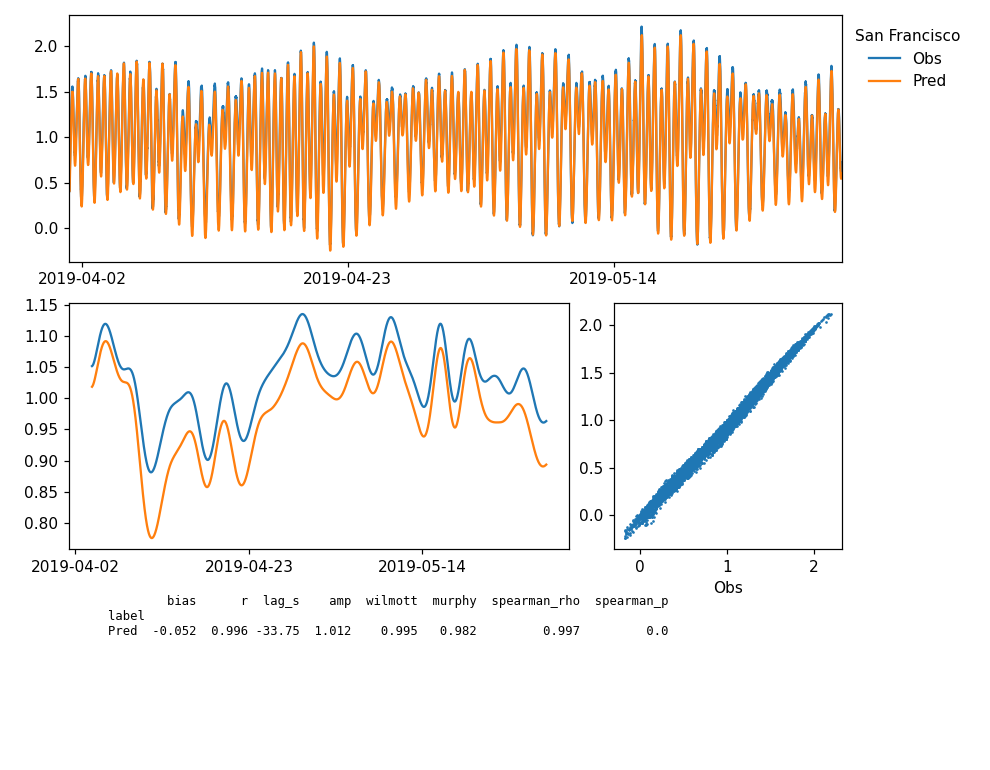

{'bias': -0.05181023216613792, 'r': 0.9962951457963896, 'lag': numpy.timedelta64(37500000,'us'), 'lag_s': 37.5, 'amp': 1.0119569031233588, 'wilmott': 0.9954922368522664, 'murphy': 0.9817319134286274, 'spearman_rho': 0.9967550749237519, 'spearman_p': 0.0}


In [104]:
if 1:
    for comp in comparisons:
        if isinstance(comp,StageCompare) and comp.name=="San Francisco":
            comp.figure()
            print(comp.calc_metrics())
        

In [21]:
%matplotlib notebook

In [79]:
model=runs.model[0]
grid=model.grid
shore_poly=grid.boundary_polygon()

INFO:join_features:0 open strings, 298 simple polygons
INFO:join_features:Building index
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=4433425849.916859, 297 potential interiors
INFO:utils:243/298


In [105]:
# dataframe with metrics, locations
recs=[]
for comp in comparisons:
    xy=comp.plot_xy()
    rec=dict(name=comp.name,x=xy[0],y=xy[1],cls=comp.__class__.__name__)
    # include the metrics
    rec.update(comp.calc_metrics()) 
    recs.append(rec)
comp_df=pd.DataFrame(recs)
comp_df

INFO:usgs_nwis:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:usgs_nwis:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:usgs_nwis:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11455420_60_2019-04-01_2019-05-01.nc


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11455420_60_2019-05-01_2019-06-01.nc
INFO:usgs_nwis:Fetching 11455420_60_2019-06-01_2019-07-01.nc
INFO:usgs_nwis:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:usgs_nwis:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:usgs_nwis:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:usgs_nwis:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:usgs_nwis:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:usgs_nwis:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:usgs_nwis:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11313433_60_2019-04-01_2019-05-01.nc


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11313433_60_2019-05-01_2019-06-01.nc
INFO:usgs_nwis:Fetching 11313433_60_2019-06-01_2019-07-01.nc
INFO:usgs_nwis:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:usgs_nwis:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:usgs_nwis:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11337190_60_2019-04-01_2019-05-01.nc


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11337190_60_2019-05-01_2019-06-01.nc
INFO:usgs_nwis:Fetching 11337190_60_2019-06-01_2019-07-01.nc
INFO:usgs_nwis:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:usgs_nwis:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:usgs_nwis:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11337080_60_2019-04-01_2019-05-01.nc


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11337080_60_2019-05-01_2019-06-01.nc
INFO:usgs_nwis:Fetching 11337080_60_2019-06-01_2019-07-01.nc
INFO:usgs_nwis:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:usgs_nwis:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:usgs_nwis:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11336600_60_2019-04-01_2019-05-01.nc


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11336600_60_2019-05-01_2019-06-01.nc
INFO:usgs_nwis:Fetching 11336600_60_2019-06-01_2019-07-01.nc
/home/rusty/miniconda3/envs/general/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/rusty/miniconda3/envs/general/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/rusty/src/stompy/stompy/model/data_comparison.py:286: RuntimeWarning: divide by zero encountered in double_scalars
  metrics['amp']=np.std(x.values[valid]) / np.std(ref.values[valid])
/home/rusty/src/stompy/stompy/utils.py:1172: RuntimeWarning: divide by zero encountered in double_scalars
  ms=1 - np.mean( (m-o)**2 )/np.mean( (xref-o)**2 )
INFO:usgs_nwis:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:usgs_nwis:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:usgs_nwis:Cached   2019-06-01 00:00:0

Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11447905_60_2019-04-01_2019-05-01.nc


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11447905_60_2019-05-01_2019-06-01.nc
INFO:usgs_nwis:Fetching 11447905_60_2019-06-01_2019-07-01.nc
INFO:usgs_nwis:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:usgs_nwis:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:usgs_nwis:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11447903_60_2019-04-01_2019-05-01.nc


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11447903_60_2019-05-01_2019-06-01.nc
INFO:usgs_nwis:Fetching 11447903_60_2019-06-01_2019-07-01.nc
INFO:usgs_nwis:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:usgs_nwis:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:usgs_nwis:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11447890_60_2019-04-01_2019-05-01.nc


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11447890_60_2019-05-01_2019-06-01.nc
INFO:usgs_nwis:Fetching 11447890_60_2019-06-01_2019-07-01.nc
INFO:usgs_nwis:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:usgs_nwis:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:usgs_nwis:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11313460_60_2019-04-01_2019-05-01.nc


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11313460_60_2019-05-01_2019-06-01.nc
INFO:usgs_nwis:Fetching 11313460_60_2019-06-01_2019-07-01.nc
INFO:usgs_nwis:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:usgs_nwis:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:usgs_nwis:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11304810_60_2019-04-01_2019-05-01.nc


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11304810_60_2019-05-01_2019-06-01.nc
INFO:usgs_nwis:Fetching 11304810_60_2019-06-01_2019-07-01.nc
INFO:usgs_nwis:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:usgs_nwis:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:usgs_nwis:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11312672_60_2019-04-01_2019-05-01.nc


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11312672_60_2019-05-01_2019-06-01.nc
INFO:usgs_nwis:Fetching 11312672_60_2019-06-01_2019-07-01.nc
INFO:usgs_nwis:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:usgs_nwis:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:usgs_nwis:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11313315_60_2019-04-01_2019-05-01.nc


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11313315_60_2019-05-01_2019-06-01.nc
INFO:usgs_nwis:Fetching 11313315_60_2019-06-01_2019-07-01.nc
INFO:usgs_nwis:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:usgs_nwis:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:usgs_nwis:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11447850_60_2019-04-01_2019-05-01.nc


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11447850_60_2019-05-01_2019-06-01.nc
INFO:usgs_nwis:Fetching 11447850_60_2019-06-01_2019-07-01.nc
INFO:usgs_nwis:Fetching 11447830_65_2019-04-01_2019-05-01.nc


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11447830_65_2019-05-01_2019-06-01.nc
INFO:usgs_nwis:Fetching 11447830_65_2019-06-01_2019-07-01.nc
INFO:usgs_nwis:Fetching 11447830_60_2019-04-01_2019-05-01.nc


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11447830_60_2019-05-01_2019-06-01.nc
INFO:usgs_nwis:Fetching 11447830_60_2019-06-01_2019-07-01.nc
INFO:usgs_nwis:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:usgs_nwis:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:usgs_nwis:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:noaa_coops:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:noaa_coops:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:noaa_coops:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:noaa_coops:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:noaa_coops:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:noaa_coops:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:noaa_coops:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:noaa_coops:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:noaa_coops:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:noaa_coops:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:noaa_coops:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:noaa_coops:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:noaa_coops:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:noaa_coops:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:noaa_coops:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


,name,x,y,cls,bias,r,lag,lag_s,amp,wilmott,murphy,spearman_rho,spearman_p,error
0,Rio Vista (SRV),615117.0,4224383.0,StageCompare,-0.439981,0.979157,-1 days +23:37:22.499990,-1357.500010,1.162934,0.735909,-0.790149,0.979154,0.0,NaN
1,Rio Vista (SRV),615232.941,4224588.2913,FlowCompare,-185.536956,0.920898,-1 days +23:14:22.499980,-2737.500020,1.389915,0.931415,0.618989,0.923510,0.0,NaN
2,Freeport,630728.0,4257433.0,StageCompare,-30.397926,0.987466,0 days 11:57:15.000320,43035.000320,0.728725,0.062432,-816.253711,0.986517,0.0,NaN
3,RYI (near match),616561.0,4230315.0,StageCompare,-1.567205,0.969182,-1 days +23:31:37.499988,-1702.500012,1.253518,0.310038,-22.715832,0.968367,0.0,NaN
4,Dutch Slough,616873.419,4208070.624,StageCompare,-0.324388,0.945527,-1 days +23:18:22.499982,-2497.500018,1.337274,0.781668,-0.493855,0.946814,0.0,NaN
5,Dutch Slough,616873.419,4208070.624,FlowCompare,-30.296759,-0.737112,0 days 04:36:30.000123,16590.000123,1.180842,0.070960,-3.166235,-0.707762,0.0,NaN
6,Jersey Point,614542.562,4212134.93,StageCompare,-0.294462,0.933844,-1 days +23:12:29.999979,-2850.000021,1.366531,0.797880,-0.359396,0.932417,0.0,NaN
7,Jersey Point,614542.562,4212134.93,FlowCompare,-863.207465,-0.800246,0 days 04:53:30.000131,17610.000131,1.352089,0.045627,-4.079679,-0.801963,0.0,NaN
8,Threemile Slough,615245.377,4218025.111,StageCompare,-0.343243,0.955453,-1 days +23:22:44.999984,-2235.000016,1.320643,0.769697,-0.606730,0.955421,0.0,NaN
9,Threemile Slough,615245.377,4218025.111,FlowCompare,-195.657530,0.756430,-1 days +22:36:14.999963,-5025.000037,1.300599,0.832966,0.156026,0.734675,0.0,NaN


In [92]:
# Map showing stage calibration across the domain
def fig_stations(comp_df,hue=None,label='name',clim=None,fmt="%s",
                 cls=None):
    fig,ax=plt.subplots()
    plot_wkb.plot_wkb(shore_poly,ax=ax,ec='0.7',lw=0.5,fc='0.9')
    fig.subplots_adjust(0,0,1,1)

    ax.axis('equal')
    ax.axis("off")

    if cls is not None:
        subset=comp_df[ comp_df.cls==cls ]
    else:
        subset=comp_df
        
    for rec in subset.itertuples():
        if np.isnan(rec.x): continue
        ax.plot(rec.x,rec.y,'ro',ms=3)
        if label:
            ax.text(rec.x,rec.y,fmt%getattr(rec,label))
    return fig

<IPython.core.display.Javascript object>


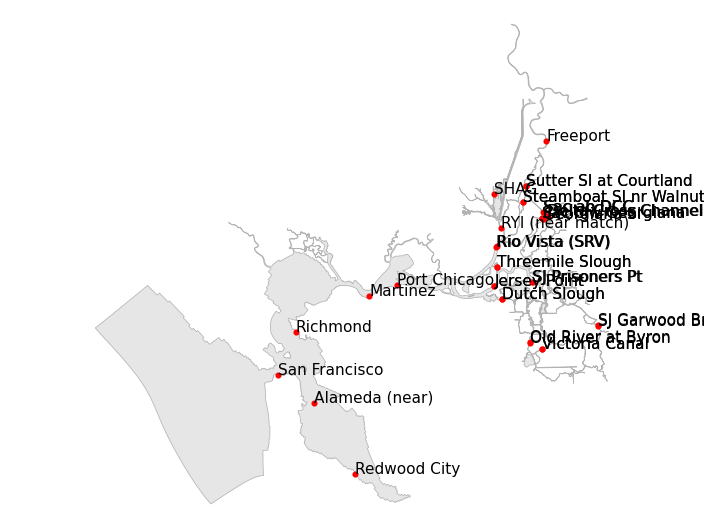

In [106]:
# Station locations with names
fig=fig_stations(comp_df,cls=None) 

<IPython.core.display.Javascript object>


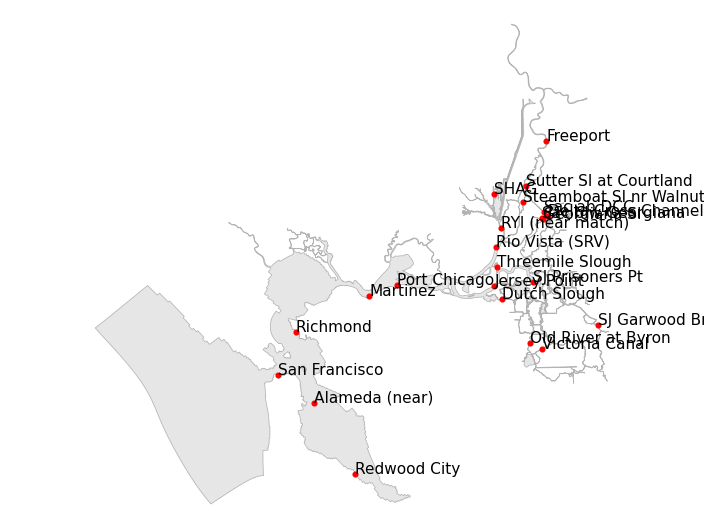

In [107]:
fig=fig_stations(comp_df,cls='StageCompare') 

<IPython.core.display.Javascript object>


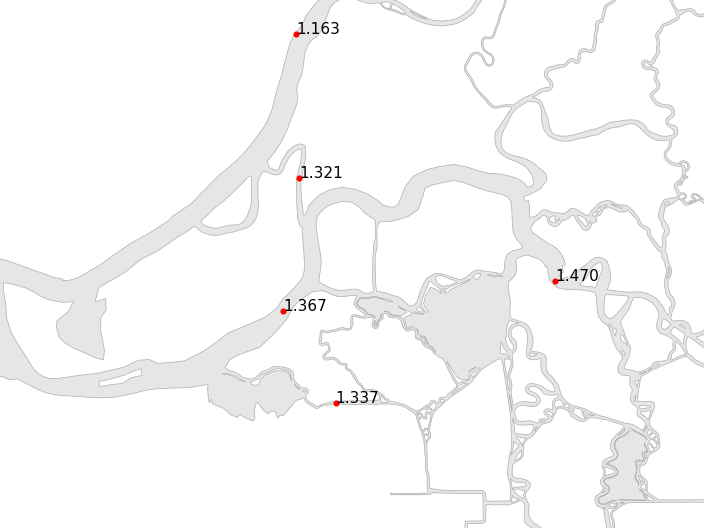

In [108]:
# WSE amplitude
# v011: amplitude acceptable throughout the Bay. Too strong
# in the W and S Delta, then weak going up mainstem Sac. DCC too strong.
fig=fig_stations(comp_df,label='amp',fmt="%.3f",cls="StageCompare") 

<IPython.core.display.Javascript object>


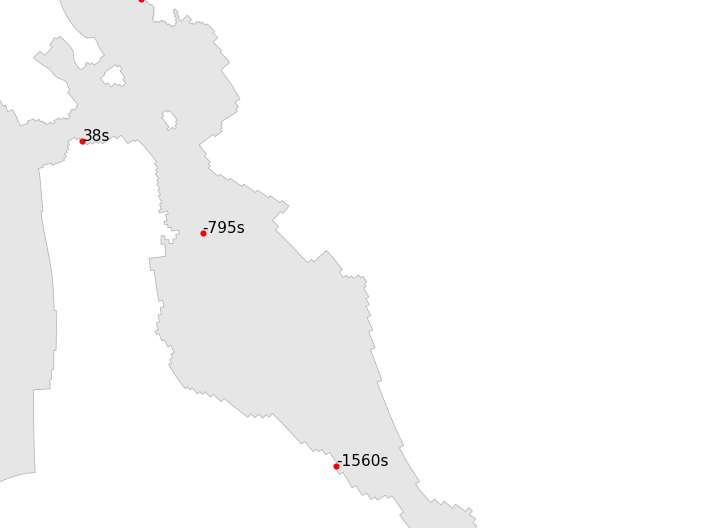

In [109]:
# WSE lag - SF is dialed, 38s late.
# North Bay is early, with parts of the South Delta over an hour
# early. South Bay is also early-- 1560s by Redwood.

# through the Bay.
# Switched to PR tides, and now it's 585s early at SF, though amplitudes
# are still pretty bad.
# v011: Adjusted PR tides for amplitude, but I got the sign wrong
#   on the lag adjustment, and it went from -585s to -1300s.
fig=fig_stations(comp_df,label='lag_s',fmt="%.0fs",cls="StageCompare")

<IPython.core.display.Javascript object>


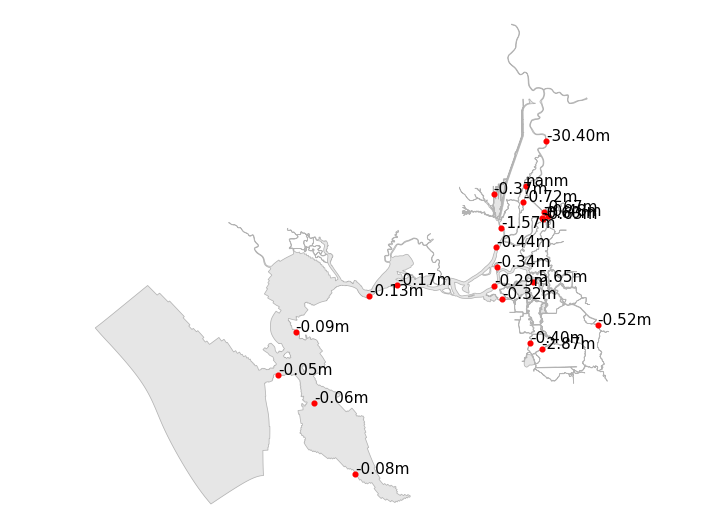

In [110]:
# WSE bias. Okay-ish in the Bay. Model is either too high in the Delta by
# 0.3m, or there is a datum issue with USGS measurements.
fig=fig_stations(comp_df,label='bias',fmt="%.2fm",cls="StageCompare")

<IPython.core.display.Javascript object>


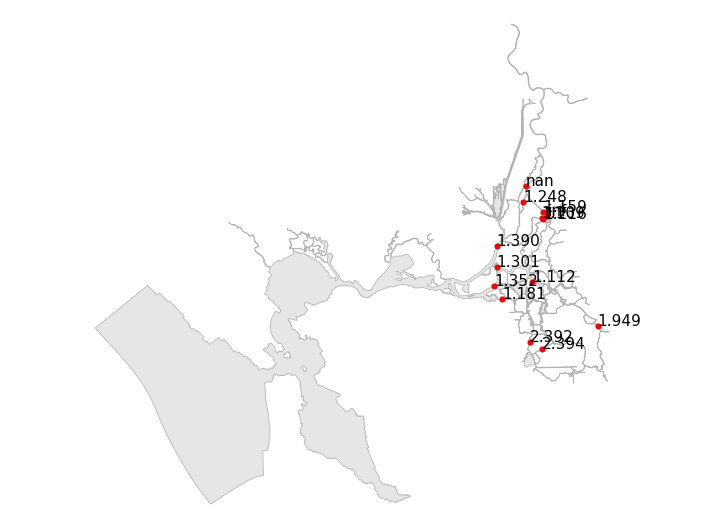

In [111]:
# Flow amplitude
# too large everywhere.
fig=fig_stations(comp_df,label='amp',fmt="%.3f",cls="FlowCompare")

<IPython.core.display.Javascript object>


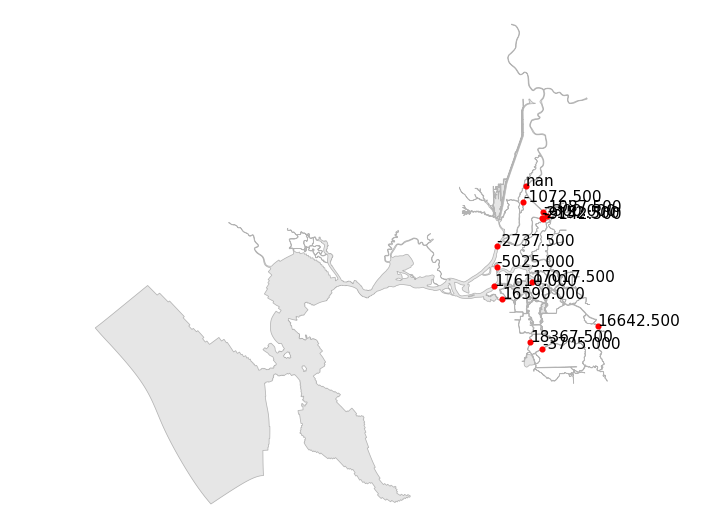

In [112]:
# Flow lag
fig=fig_stations(comp_df,label='lag_s',fmt="%.3f",cls="FlowCompare")

<IPython.core.display.Javascript object>


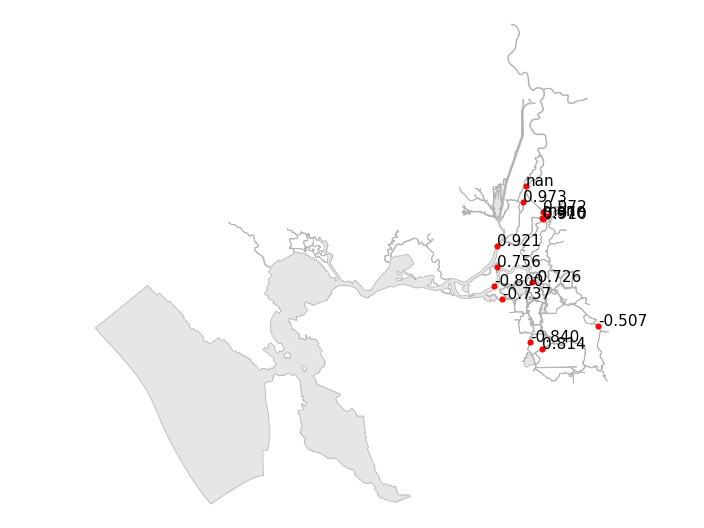

In [113]:
# Flow R
fig=fig_stations(comp_df,label='r',fmt="%.3f",cls="FlowCompare")

<IPython.core.display.Javascript object>


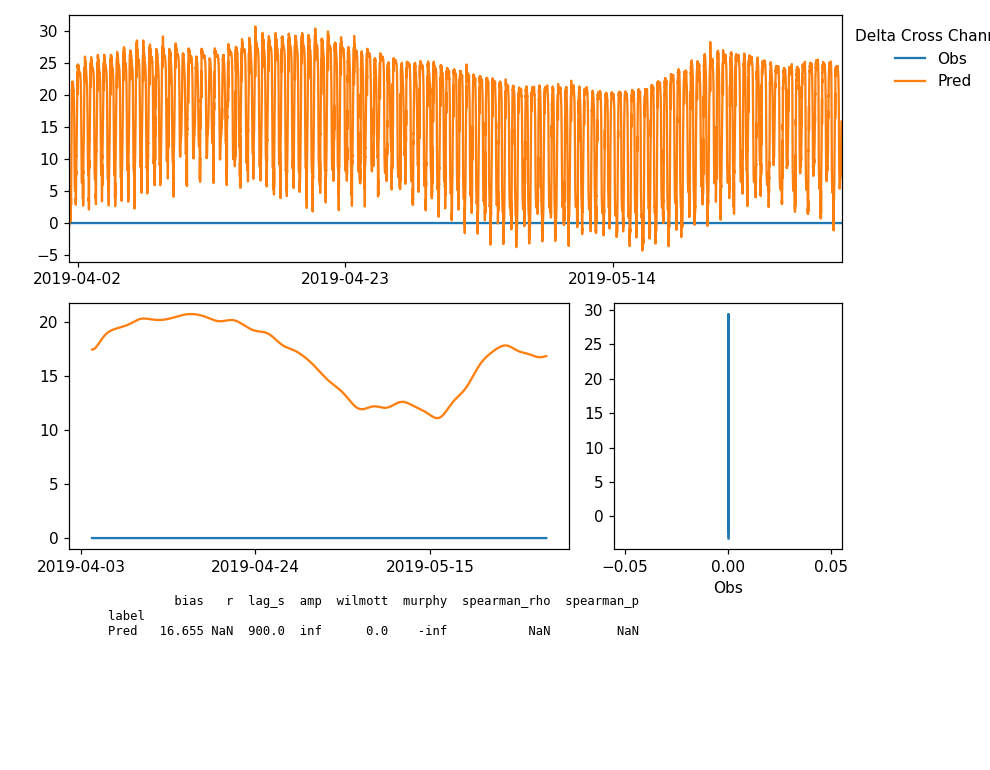

/home/rusty/miniconda3/envs/general/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/rusty/miniconda3/envs/general/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/rusty/src/stompy/stompy/model/data_comparison.py:286: RuntimeWarning: divide by zero encountered in double_scalars
  metrics['amp']=np.std(x.values[valid]) / np.std(ref.values[valid])
/home/rusty/src/stompy/stompy/utils.py:1172: RuntimeWarning: divide by zero encountered in double_scalars
  ms=1 - np.mean( (m-o)**2 )/np.mean( (xref-o)**2 )


{'bias': 16.65491897934031, 'r': nan, 'lag': numpy.timedelta64(-300000002,'us'), 'lag_s': -300.000002, 'amp': inf, 'wilmott': 0.0, 'murphy': -inf, 'spearman_rho': nan, 'spearman_p': nan}


/home/rusty/miniconda3/envs/general/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/rusty/miniconda3/envs/general/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/rusty/src/stompy/stompy/model/data_comparison.py:286: RuntimeWarning: divide by zero encountered in double_scalars
  metrics['amp']=np.std(x.values[valid]) / np.std(ref.values[valid])
/home/rusty/src/stompy/stompy/utils.py:1172: RuntimeWarning: divide by zero encountered in double_scalars
  ms=1 - np.mean( (m-o)**2 )/np.mean( (xref-o)**2 )


In [116]:
if 1:
    for comp in comparisons:
        if isinstance(comp,FlowCompare) and comp.name=="Delta Cross Channel":
            comp.figure()
            print(comp.calc_metrics())
